In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
#exporti
from fastai.tabular.all import * 
from tabnet.utils import *
from tabnet.model import *

# Abstract 

Tabular data problems are still very prevalent in today's world, especially in big corporations that amass large amounts of data for analysis. 

Even though this domain is popular, it's not as widely researched as computer vision, audio etc. For example, there are [papers](https://arxiv.org/abs/1604.07379) using self-supervised learning in CV problems as far back as 2016, while the first known one for Tabular data has been released in August 2019. 

For these reasons, I wanted to implement a self-supervised approach for Tabular Data. 

My goals were to: 
1. Test if self-supervised learning for tabular data speeds up the training process and by how much, and if using a `Curricular Learning` improves the self-supervised learning process.  
1. Test if a modle trained in a self-supervised fashion gives better results in a highly imbalanced data set

To do so I've implemented a relatively new (Aug 2019) SOTA Tabular Data DL model called [Tabnet](#https://arxiv.org/pdf/1908.07442.pdf). I've also taken the time to learn the [fastai framework](https://docs.fast.ai/) (a DL framework implemented using `pytorch`) for this project which helped me decouple the different parts and run experiments efficiently. 

I've tested this approach on 3 different datasets: 
1. Adult Census Income - where the task is to distinguish whether a person's income is above $50,000
1. Forest Cover - classifying the forst cover type from cartographic variables.
1. Poker Hand - classifying the poker hand from the raw suit and rank attributes of the cards.

# Adult 

In [3]:
adult_path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_path/'adult.csv')

In [4]:
tabnet_args = dict(n_d=16, n_a=16, n_steps=5, virtual_batch_size=256, gamma=1.5)

### Before Self Supervision 

In [5]:
splits = RandomSplitter(valid_pct=0.2)(range_of(df))
to = TabularPandas(df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
                   cont_names = ['age', 'fnlwgt', 'education-num'],
                   y_names='salary',
                   splits=splits)
dls = to.dataloaders(bs=1024)


In [6]:
model = TabNetClassifier(linear_head, to, **tabnet_args)

In [7]:
learn = Learner(dls, model, CrossEntropyLossFlat(), metrics=[accuracy])

SuggestedLRs(lr_min=0.2290867567062378, lr_steep=0.004365158267319202)

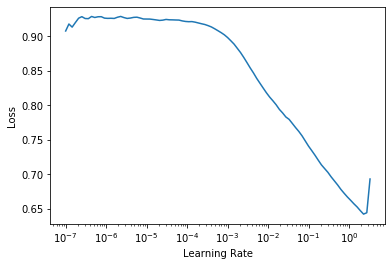

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(150, 1e-1/2)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-994453a49d62>", line 1, in <module>
    learn.fit_one_cycle(150, 1e-1/2)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/logargs.py", line 56, in _f
    return inst if to_return else f(*args, **kwargs)
  File "/workspace/libraries/fastai/fastai/callback/schedule.py", line 113, in fit_one_cycle
    self.fit(n_epoch, cbs=ParamScheduler(scheds)+L(cbs), reset_opt=reset_opt, wd=wd)
  File "/opt/conda/lib/python3.7/site-packages/fastcore/logargs.py", line 56, in _f
    return inst if to_return else f(*args, **kwargs)
  File "/workspace/libraries/fastai/fastai/learner.py", line 207, in fit
    self._with_events(self._do_fit, 'fit', CancelFitException, self._end_cleanup)
  File "/workspace/libraries/fastai/fastai/learner.py", line 155, in _with_events
    try:       self

RuntimeError: python_error

# Forest Cover DS

In [ ]:
data_dir = Path('./data')

In [ ]:
def extract_gzip(file, dest=None):
    import gzip
    dest = dest or Path(dest)
    with gzip.open(file, 'rb') as f_in:
        with open(dest / file.stem, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [ ]:
forest_type_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz'
forest_path = untar_data(forest_type_url, dest=data_dir, extract_func=extract_gzip)

In [ ]:
target = "Covertype"

cat_names = [
    "Wilderness_Area1", "Wilderness_Area2", "Wilderness_Area3",
    "Wilderness_Area4", "Soil_Type1", "Soil_Type2", "Soil_Type3", "Soil_Type4",
    "Soil_Type5", "Soil_Type6", "Soil_Type7", "Soil_Type8", "Soil_Type9",
    "Soil_Type10", "Soil_Type11", "Soil_Type12", "Soil_Type13", "Soil_Type14",
    "Soil_Type15", "Soil_Type16", "Soil_Type17", "Soil_Type18", "Soil_Type19",
    "Soil_Type20", "Soil_Type21", "Soil_Type22", "Soil_Type23", "Soil_Type24",
    "Soil_Type25", "Soil_Type26", "Soil_Type27", "Soil_Type28", "Soil_Type29",
    "Soil_Type30", "Soil_Type31", "Soil_Type32", "Soil_Type33", "Soil_Type34",
    "Soil_Type35", "Soil_Type36", "Soil_Type37", "Soil_Type38", "Soil_Type39",
    "Soil_Type40"
]

cont_names = [
    "Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology", "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]

feature_columns = (
    cont_names + cat_names + [target])

In [ ]:
df = pd.read_csv(forest_path, header=None, names=feature_columns); df.head()
df = df_shrink(df)

In [ ]:
procs = [Categorify, FillMissing, Normalize]
splits = RandomSplitter(0.05)(range_of(df))

In [ ]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names=target, y_block = CategoryBlock(), splits=splits)
dls = to.dataloaders(bs=64*64*4)

In [ ]:
model = TabNetClassifier(get_emb_sz(to), len(to.cont_names), dls.c, n_d=64, n_a=64, n_steps=5, virtual_batch_size=256)
opt_func = partial(Adam, wd=0.01, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

In [ ]:
learn.fit_one_cycle(120)

# Poker Hand DS

In [ ]:
BASE_DIR = Path.home().joinpath('data/tabnet/poker')

In [ ]:
df = pd.read_csv(BASE_DIR.joinpath('train.csv'))
df.head()

In [ ]:
cat_names = ['S1', 'S2', 'S3', 'S4', 'S5', 'C1', 'C2', 'C3', 'C4', 'C5']
cont_names = []
target = ['hand']

In [ ]:
procs = [Categorify, Normalize]
splits = RandomSplitter(0.05)(range_of(df))

In [ ]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names=target, y_block = CategoryBlock(), splits=splits)
dls = to.dataloaders(bs=64*4)

In [ ]:
model = TabNet(get_emb_sz(to), len(to.cont_names), dls.c, n_d=16, n_a=16, 
                    n_steps=5, virtual_batch_size=256, gamma=1.5)

In [ ]:
opt_func = partial(Adam, eps=1e-5)
learn = Learner(dls, model, CrossEntropyLossFlat(), opt_func=opt_func, lr=3e-2, metrics=[accuracy])

In [ ]:
learn.fit_one_cycle(1000)

# Export

In [ ]:
from nbdev.export import notebook2script
notebook2script()